In [1]:
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Formatting
plt.rc("text", usetex=True)
plt.rc("font", size=24, family="serif")
plt.rc("errorbar", capsize=3)

In [3]:
#This has the Catalog object
from catalog import *
#Select a simulation
length       = 2000 #Mpc/h comoving
scale_factor = 1.
#Create the Catalog object
cat = Catalog(length, scale_factor)

In [4]:
print(len(cat.property("Spin")))
cat.add_property("lnSpin", np.log(cat.property("Spin")))

7950


In [5]:
#Write a model for splashback that looks something like the accretion rate model
def get_X_model(params, args):
    A,B,C,D = params
    c = args["c200b"]
    S = args["Spin"]
    q = args["c_to_a"]
    return A + B*S + C*c + D*q

In [6]:
def MSE(params, args):
    X_model = get_X_model(params, args)
    X = args["X"]
    return np.mean((X_model-X)**2)

In [7]:
#Assembled the arguments
args = {"X": cat.property("X_Rsp_mean"), "c200b":cat.property("c200b"), 
        "Spin": cat.property("Spin"), "c_to_a": cat.property("c_to_a")}
for key in args.keys():
    print np.mean(args[key])

0.8778694701466275
0.03089652201257862
7.271151998115432
0.4070427836477988


In [8]:
guess = [1., 1., 1., 1.]
result = op.minimize(MSE, guess, args=(args,))
print result

      fun: 0.025923322255129947
 hess_inv: array([[ 1.15564635e+01, -7.02983043e+01, -2.29659891e-01,
        -1.76133671e+01],
       [-7.02983043e+01,  1.54888357e+03,  1.43421981e+00,
         2.90402976e+01],
       [-2.29659891e-01,  1.43421981e+00,  5.53050211e-02,
        -5.40900007e-01],
       [-1.76133671e+01,  2.90402976e+01, -5.40900007e-01,
         5.04877297e+01]])
      jac: array([3.58559191e-08, 2.56113708e-09, 3.37837264e-07, 6.28642738e-09])
  message: 'Optimization terminated successfully.'
     nfev: 180
      nit: 29
     njev: 30
   status: 0
  success: True
        x: array([ 0.77795714, -1.23721455,  0.00712156,  0.21215462])


In [9]:
#Define a function that takes in points and plots the binned mean and poisson noise
def get_mean_and_noise(x, y, bins):
    ym = np.zeros(len(bins)-1)
    yn = np.zeros_like(ym)
    mids = (bins[:-1]+bins[1:])/2
    for i in range(len(bins)-1):
        inds = (x>=bins[i])*(x<bins[i+1])
        ym[i] = np.mean(y[inds])
        yn[i] = np.std(y[inds]) / np.sqrt(len(y[inds]))
    return mids, ym, yn

In [10]:
def get_data_and_model(name, name1, name2, ptile1, ptile2, the_max = 25, greater=True):
    names = ["c200b", "c_to_a", "Spin"]
    if name not in names:
        raise Exception("bad name")
    if name1 not in names:
        raise Exception("bad name1")
    if name2 not in names:
        raise Exception("bad name2")

    x = np.linspace(min(cat.property(name)), the_max, 15)
    p1_median = np.percentile(cat.property(name1), ptile1)
    p2_median = np.percentile(cat.property(name2), ptile2)

    if greater:
        inds = (cat.property(name1)>p1_median)*(cat.property(name2)>p2_median)
    else:
        inds = (cat.property(name1)<p1_median)*(cat.property(name2)<p2_median)
    temp_args = {name1: np.mean(cat.property(name1)[inds]), 
                 name2: np.mean(cat.property(name2)[inds]), name: x}
    #print p1_median, temp_args
    mid, sm, sn = get_mean_and_noise(cat.property(name)[inds], 
                                     cat.property("X_Rsp_mean")[inds], x)
    #Return binned data and model
    return mid, sm, sn, x, get_X_model(result.x, temp_args)

/Users/tmcclintock/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tmcclintock/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/tmcclintock/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/tmcclintock/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/tmcclintock/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


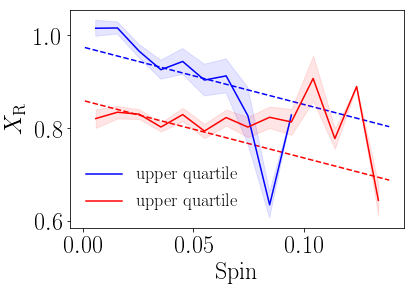

In [11]:
mid, sm, sn, x, m = get_data_and_model("Spin", "c200b", "c_to_a", 
                                       75, 75, max(cat.property("Spin")))
plt.plot(mid, sm, c='b', zorder=10, label="upper quartile")
plt.fill_between(mid, sm-sn, sm+sn, color='b', zorder=10, alpha=0.1)
plt.plot(x, m, 'b--')

mid, sm, sn, x, m = get_data_and_model("Spin", "c200b", "c_to_a", 
                                       25, 25, max(cat.property("Spin")), False)
plt.plot(mid, sm, c='r', zorder=10, label="upper quartile")
plt.fill_between(mid, sm-sn, sm+sn, color='r', zorder=10, alpha=0.1)
plt.plot(x, m, 'r--')
plt.xlabel(r"Spin")
plt.ylabel(r"$X_{\rm R}$")
plt.legend(loc=0, frameon=False, fontsize=18)
plt.savefig("spin_fit.png", dpi=300, bbox_inches="tight")

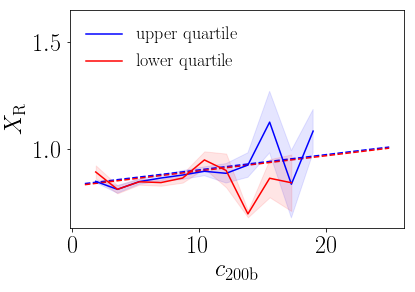

In [12]:
mid, sm, sn, x, m = get_data_and_model("c200b", "Spin", "c_to_a", 
                                       75, 75, 25)
#plt.plot(mid, sm, c='b', zorder=10, label=r"upper quartile of $q$, top decile of $S$")
plt.plot(mid, sm, c='b', zorder=10, label=r"upper quartile")
plt.fill_between(mid, sm-sn, sm+sn, color='b', zorder=10, alpha=0.1)
plt.plot(x, m, 'b--')
mid, sm, sn, x, m = get_data_and_model("c200b", "Spin", "c_to_a", 
                                       25, 25, 25, False)
plt.plot(mid, sm, c='r', zorder=10, label="lower quartile")
plt.fill_between(mid, sm-sn, sm+sn, color='r', zorder=10, alpha=0.1)
plt.plot(x, m, 'r--')
plt.xlabel(r"$c_{\rm 200b}$")
plt.ylabel(r"$X_{\rm R}$")
plt.legend(loc=0, frameon=False, fontsize=18)
plt.savefig("c200b_fit.png", dpi=300, bbox_inches="tight")

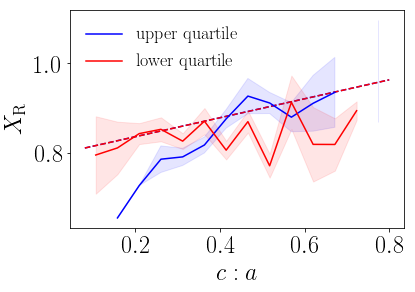

In [13]:
mid, sm, sn, x, m = get_data_and_model("c_to_a", "Spin", "c200b", 
                                       75, 75, 0.8)
plt.plot(mid, sm, c='b', zorder=10, label="upper quartile")
plt.fill_between(mid, sm-sn, sm+sn, color='b', zorder=10, alpha=0.1)
plt.plot(x, m, 'b--')

mid, sm, sn, x, m = get_data_and_model("c_to_a", "Spin", "c200b", 
                                       25, 25, 0.8, False)
plt.plot(mid, sm, c='r', zorder=10, label="lower quartile")
plt.fill_between(mid, sm-sn, sm+sn, color='r', zorder=10, alpha=0.1)
plt.plot(x, m, 'r--')
plt.xlabel(r"$c:a$")
plt.ylabel(r"$X_{\rm R}$")
plt.legend(loc=0, frameon=False, fontsize=18)
plt.savefig("axisratio_fit.png", dpi=300, bbox_inches="tight")

In [14]:
print np.percentile(cat.property("Spin"), [25, 50, 75])

[0.01781  0.02723  0.039425]


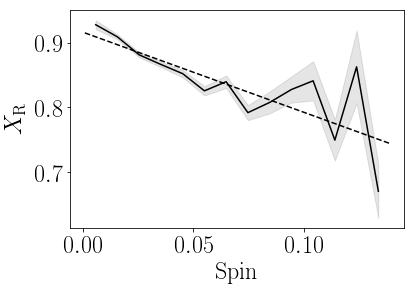

In [16]:
mid, sm, sn, x, m = get_data_and_model("Spin", "c200b", "c_to_a", 
                                       0, 0, max(cat.property("Spin")))
plt.plot(mid, sm, c='k', zorder=10, label="upper quartile")
plt.fill_between(mid, sm-sn, sm+sn, color='k', zorder=10, alpha=0.1)
plt.plot(x, m, 'k--')

plt.xlabel(r"Spin")
plt.ylabel(r"$X_{\rm R}$")
#plt.legend(loc=0, frameon=False, fontsize=18)
plt.savefig("spin_all_fit.png", dpi=300, bbox_inches="tight")

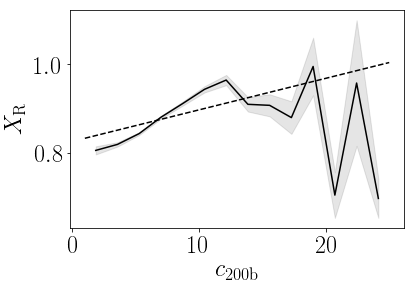

In [18]:
mid, sm, sn, x, m = get_data_and_model("c200b", "Spin", "c_to_a", 
                                       0, 0, 25)
plt.plot(mid, sm, c='k', zorder=10, label="upper quartile")
plt.fill_between(mid, sm-sn, sm+sn, color='k', zorder=10, alpha=0.1)
plt.plot(x, m, 'k--')

plt.xlabel(r"$c_{\rm 200b}$")
plt.ylabel(r"$X_{\rm R}$")
#plt.legend(loc=0, frameon=False, fontsize=18)
plt.savefig("conc_all_fit.png", dpi=300, bbox_inches="tight")

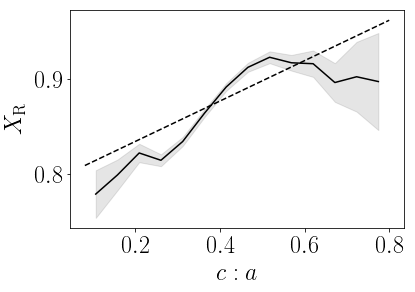

In [19]:
mid, sm, sn, x, m = get_data_and_model("c_to_a", "Spin", "c200b", 
                                       0, 0, 0.8)
plt.plot(mid, sm, c='k', zorder=10, label="upper quartile")
plt.fill_between(mid, sm-sn, sm+sn, color='k', zorder=10, alpha=0.1)
plt.plot(x, m, 'k--')

plt.xlabel(r"$c:a$")
plt.ylabel(r"$X_{\rm R}$")
#plt.legend(loc=0, frameon=False, fontsize=18)
plt.savefig("axisratio_all_fit.png", dpi=300, bbox_inches="tight")